### FRB Event Rate

Calculate the expected FRB event rate for thew ALFABURST survey based on Lorimer et al. 2013

**Assumptions**

1. Pulse width is approximately 1 ms
2. FRB is a standard candles
3. Thornton et al. 2013 correctly relates flux density to redshift

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from matplotlib import rc

%matplotlib inline
rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (10, 8)

Equation 6 of Karastergiou et al. 2015 is derived from the radiometer equation:

$$
S_{min} = \textrm{SEFD} \frac{\textrm{SNR}_{min}}{\sqrt{D \; \Delta \tau \; \Delta \nu}}
$$

where $S_{min}$ is the minimum flux density (in Jy) detection rate. This is based on the telescope SEFD, the minimum SNR detection level $\textrm{SNR}_{min}$ and the decimation rate $D$ compared to the native instrumental time resolution $\tau$, this comes from the search pipeline which averages together spectra to search for scattered pulses. ALFABURST has a native resolution of $\Delta \tau = 256 \; \mu s$, effective bandwidth $\Delta \nu = 56 \textrm{MHz}$, and $\textrm{SNR}_{min} = 10$.

For reference see:
* https://www.cv.nrao.edu/course/astr534/Radiometers.html
* http://www.naic.edu/alfa/performance/
* https://casper.berkeley.edu/astrobaki/index.php/Radiometer_Equation_Applied_to_Telescopes
* https://science.nrao.edu/facilities/vla/docs/manuals/oss/performance/sensitivity

In [2]:
# Parameters

# From Minimum flux density detection, based on radiometer equation
#SEFD = 3. # Jy, SEFD of ALFA (main beam)
#threshold = 10. # SNR threshold of detection pipeline
#pulseWidth = 2.**(np.arange(0,7)) * 256. # us, expected pulse width
#tRes = 256. # us, ALFABURST spectra time resolution
#dFactor = pulseWidth / tRes# decimation factor
#bw = 56. * 1e6 # ALFABURST effective bandwidth in Hz
#sMin = SEFD * (threshold / np.sqrt(dFactor * (tRes * 1e-6) * bw))

# From ALFA_Beam_Response.ipynb
#Survey Metric         2 d2h (-3 dB) 20 d2h     40 d2h    53 d2h(Full)
#----------------------------------------------------------------------------------------
# Pulse Width 8192 us: 0.028 Jy     0.152 Jy    0.489 Jy   22.199 Jy
pulseWidth = np.array([8192., 8192., 8192., 8192.])
sMin = np.array([0.028, 0.152, 0.489, 22.199])
surveyMetric = np.array([2., 20., 40., 53.]) # deg^2 hours

fObsMin = 1347e6 # ALFABURST 56 MHz bandwidth system min frequency
fObsMax = 1403e6 # ALFABURST 56 MHz bandwidth system max frequency

alphas = [-2., -1.1, 0., 1., 2.] # spectral indicies to model

zMin = 0.01
zMax = 7.997 # minimum z based on pointing and NE2001 from frb_search_volume.ipynb

In [3]:
#print SEFD * (5.1 / np.sqrt(8. * (tRes * 1e-6) * bw)) * 1000.

In [4]:
print 'The minimum flux density detection for a given pulse width is:'
for sMinVal, pwVal, smVal in zip(sMin, pulseWidth, surveyMetric):
    print '\t %.1f mJy for a pulse width of %.0f us (Survey Metric: %.0f deg^2 hrs)'%(sMinVal*1000., pwVal, smVal)

The minimum flux density detection for a given pulse width is:
	 28.0 mJy for a pulse width of 8192 us (Survey Metric: 2 deg^2 hrs)
	 152.0 mJy for a pulse width of 8192 us (Survey Metric: 20 deg^2 hrs)
	 489.0 mJy for a pulse width of 8192 us (Survey Metric: 40 deg^2 hrs)
	 22199.0 mJy for a pulse width of 8192 us (Survey Metric: 53 deg^2 hrs)


In [5]:
#plt.plot(pulseWidth/1000., sMin*1000.)
##plt.legend()
#plt.xlim(pulseWidth[0]/1000., pulseWidth[-1]/1000.)
#plt.xlabel('Pulse Width (ms)')
#plt.ylabel('Flux Density (mJy)')
#plt.title('Sensitivity of ALFABURST to Pulses')

In [6]:
def coMovingDist(z):
    """Co-moving distance in Gpc, Eq. 3 from Lorimer et al. 2013
    z: float, redshift
    """
    c = 299792.458 # km s^-1
    H0 = 68. # km s^-1 Mpc^-1
    OmegaM = 0.32
    OmegaLambda = 0.68
    
    integrand = lambda zp: 1. / np.sqrt(OmegaM * ((1. + zp)**3.) + OmegaLambda)
    dd, err = scipy.integrate.quad(integrand, 0., z)
    return ((c/H0) * dd) * 1e-3

def coMovingVol(z):
    """Co-moving volume in Gpc^3
    z: float, redshift"""
    return (4./3.)*(coMovingDist(z)**3.)

def calcLModel(sPeakRef=1., alphaRef=-1.4, zRef=0.75, fLumMin=1e7, fLumMax=1e10, fObsMin=1182e6, fObsMax=1582e6):
    """Calculate the standard candle FRB bolometric luminosity based on Thornton et al. 2013 model, this is used
    to calibrate the flux-redshift relationship
    sPeakRef: float, Jy, peak flux density, Thornton et al.: 1.
    alphaRef: float, spectal index, Thornton et al.: -1.4
    zRef: float, redshift, Thornton et al.: 0.75
    fLumMin: float, Hz, minimum frequency over which the source emits, Lorimer et al.: 1e7
    fLumMax: float, Hz, maximum frequency over which the source emits, Lorimer et al.: 1e10
    fObsMin: float, Hz, minimum observing frequency, Thornton et al.: 1186 MHz
    fObsMax: float, Hz, maximum observing frequency, Thornton et al.: 1582 MHz"""
    sPeakRefErgs = sPeakRef * 1e-19 # unit: erg s^-1 ; 1 Jy = 10^-26 W = 10^-19 erg s^-1
    
    dd = coMovingDist(zRef) * 3.086e25 # Convert from Gpc to m

    LL = ((fObsMax-fObsMin)/((fObsMax**(alphaRef+1.))-(fObsMin**(alphaRef+1.)))) * sPeakRefErgs \
            * 4. * np.pi * (dd**2.) \
            * (((fLumMax**(alphaRef+1.))-(fLumMin**(alphaRef+1.)))/((1.+zRef)**(alphaRef-1.)))
    return LL

def calcSpeak(LModel, z, alpha, fObsMin, fObsMax, fLumMin=1e7, fLumMax=1e10):
    """Calculate the peak flux density, Lorimer et al. 2013 eq. 9
    LModel: float, ergs s^-1, bolometric luminosity model output of calcLModel()
    z: float, redshift of source
    alpha: float, spectral index of FRB standard candle model
    fObsMin: float, Hz, minimum observing frequency
    fObsMax: float, Hz, maximum observing frequency
    fLumMin: float, Hz, minimum frequency over which the source emits, Lorimer et al.: 1e7
    fLumMax: float, Hz, maximum frequency over which the source emits, Lorimer et al.: 1e10
    """
    dd = coMovingDist(z) * 3.086e25 # Convert from Gpc to m
    
    sPeak = (LModel * ((1. + z)**(alpha-1.))) \
            * (1. / (4. * np.pi * dd**2. * ((fLumMax**(alpha+1.)) - (fLumMin**(alpha+1.)))) ) \
            * (((fObsMax**(alpha+1.)) - (fObsMin**(alpha+1.)))/(fObsMax - fObsMin))

    return sPeak / 1e-19

Smin: 28.000000 mJy 	 Alpha: -2.000000 	 zMax: 2.438110 	 surveyMetric: 2
Smin: 28.000000 mJy 	 Alpha: -1.100000 	 zMax: 3.132972 	 surveyMetric: 2
Smin: 28.000000 mJy 	 Alpha: 0.000000 	 zMax: 5.771883 	 surveyMetric: 2
Smin: 28.000000 mJy 	 Alpha: 1.000000 	 zMax: 7.997000 	 surveyMetric: 2
Smin: 28.000000 mJy 	 Alpha: 2.000000 	 zMax: 3.773181 	 surveyMetric: 2
Smin: 152.000000 mJy 	 Alpha: -2.000000 	 zMax: 1.415337 	 surveyMetric: 20
Smin: 152.000000 mJy 	 Alpha: -1.100000 	 zMax: 1.587101 	 surveyMetric: 20
Smin: 152.000000 mJy 	 Alpha: 0.000000 	 zMax: 2.024317 	 surveyMetric: 20
Smin: 152.000000 mJy 	 Alpha: 1.000000 	 zMax: 3.562380 	 surveyMetric: 20
Smin: 152.000000 mJy 	 Alpha: 2.000000 	 zMax: 3.773181 	 surveyMetric: 20
Smin: 489.000000 mJy 	 Alpha: -2.000000 	 zMax: 0.954699 	 surveyMetric: 40
Smin: 489.000000 mJy 	 Alpha: -1.100000 	 zMax: 1.001543 	 surveyMetric: 40
Smin: 489.000000 mJy 	 Alpha: 0.000000 	 zMax: 1.079618 	 surveyMetric: 40
Smin: 489.000000 mJy 	 Alpha:

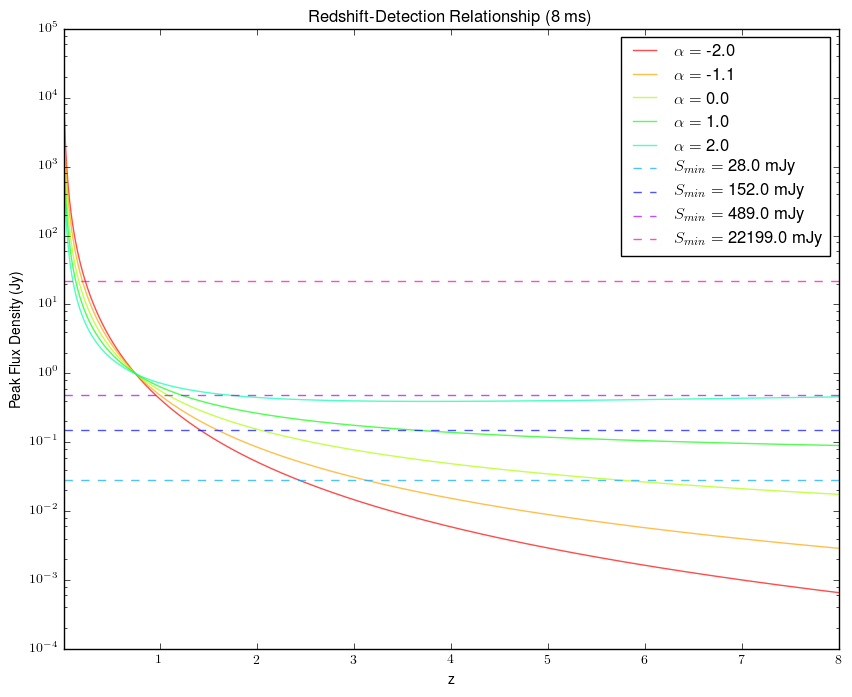

In [7]:
zArr = np.linspace(zMin, zMax, 1024)
sPeakArr = np.zeros((len(alphas), len(zArr)))

cmap = plt.cm.hsv
colors = iter(cmap(np.linspace(0, 0.9, len(alphas) + len(sMin))))

for aid, alpha in enumerate(alphas):
    LModel = calcLModel(alphaRef=alpha)
    for zid,zz in enumerate(zArr):
        sPeakArr[aid, zid] = calcSpeak(LModel, zz, alpha, fObsMin, fObsMax)
    plt.semilogy(zArr, sPeakArr[aid], color=next(colors), alpha=0.7, label=r'$\alpha =$ %1.1f'%alpha)

idxArr = np.zeros((len(sMin),len(alphas)), dtype='int')
#for sMinVal, pwVal in zip(sMin, pulseWidth):
for smid, sMinVal in enumerate(sMin):
    pwVal = pulseWidth[smid]
    plt.axhline(y=sMinVal, xmin=0.0, xmax=1.0, color=next(colors), linestyle="--", alpha=0.7, \
                #label='$S_{min}=$ %1.1f mJy (%.0f ms)'%(sMinVal*1000., pwVal/1000.))
                label='$S_{min}=$ %1.1f mJy'%(sMinVal*1000.))
    for aid, alpha in enumerate(alphas):
        idx = np.argmin(np.abs(sPeakArr[aid] - sMinVal)) # array index of nearest sMin/alpha flux density crossing
        #print alpha, sMinVal, idx, zArr[idx]
        idxArr[smid, aid] = idx
        # find maximum redshift to compute volume
        print 'Smin: %f mJy \t Alpha: %f \t zMax: %f \t surveyMetric: %.0f'%(sMinVal*1000., alpha, zArr[idx],\
                                                                             surveyMetric[smid])

plt.legend()
plt.xlim(zMin, zMax)
plt.xlabel('z')
plt.ylabel('Peak Flux Density (Jy)')
#plt.title('Redshift-SEFD Detection Relationship')
plt.title('Redshift-Detection Relationship (%.0f ms)'%(pulseWidth[0]/1000.))

**Figure:** Similar to Figure 6 of Karastergiou et al. 2015, and Figure 2a of Lorimer et al. 2013. Peak flux density of the Lorimer et al. 2013 population model as a function of redshift $z$ and spectral index $\alpha$. Lines of minimum dectection using the ALFABURST system is shown as dashed lines for different decimation levels.

In [8]:
# lorimer 2b, karastergious 6 - rate to redshift relationship
def thorntonRate(z):
    """Compute the event rate using Thornton et al. 2013 values as computed by Lormier et al. 2013
    z: float, redshift
    returns: array, [low rate, expected rate, high rate]"""
    dd = coMovingDist(z)
    dNorm = coMovingDist(0.75) # Thornton rate is based on events at z=0.75
    rateNorm = np.array([0.5 * 10**4, 10**4, 1.6 * 10**4]) # Thornton et al. 2013: rate = 10000 (error: +6000/-5000)
    rate = rateNorm * ((dd / dNorm)**3.)
    return rate

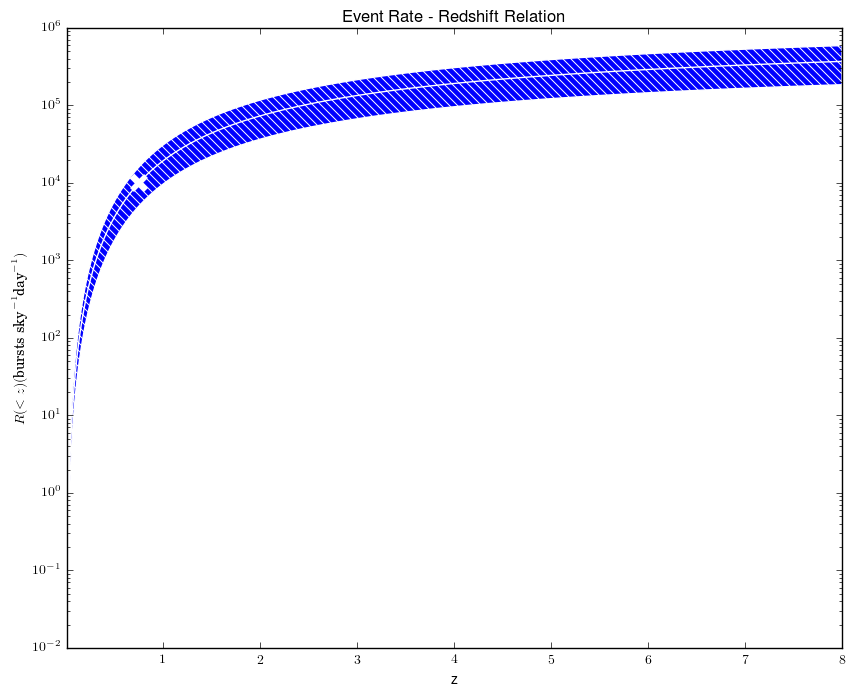

In [9]:
expectedRates = np.zeros((zArr.shape[0], 3))
for zid,zz in enumerate(zArr):
    expectedRates[zid,:] = thorntonRate(zz)

plt.semilogy(zArr, expectedRates[:,1], "w")
plt.fill_between(zArr, expectedRates[:,0], expectedRates[:,2], alpha=1.0, facecolor="blue", edgecolor="white", \
                 hatch="\\\\\\")

plt.plot(0.75, 1e4, "wx", markersize=10, markeredgewidth=4) # plot Thornton et al. (2013) rate

plt.xlim(zMin, zMax)
plt.xlabel('z')
plt.ylabel(r'$R (< z) (\textrm{bursts sky}^{-1} \textrm{day}^{-1})$')

plt.title('Event Rate - Redshift Relation')

**Figure:** Implied redshift to event rate relation based on Thornton et al. 2013 event rate of $10000^{+6000}_{-5000} \; \textrm{bursts sky}^{-1} \textrm{day}^{-1}$ at $z = 0.75$ (white cross).

In [10]:
# Determine expected number of detections based on rate per sky, time for current sky,time coverage

# From frb_search_volume.ipynb:
# Observing time outside the galactic plane (+/-7.0 degrees) = 2175300 s
# Total area surveyed = 4.748e+03 sq. deg
#obsTimeSec = 2175300. # seconds
obsTimeSec = 2175300. * 0.25 # seconds
obsTimeDay = obsTimeSec / (24. * 60. * 60.) # days
nBeams = 7. # number of beams, for ALFA this is 7
beamFWHM = nBeams * (3.5 / 60.) # beam FWHM in degrees
areaDeg = np.pi * (beamFWHM/2.)**2. # beam area in deg^2

# 4 * pi steradian in a sphere
sqDegPerSky = 4. * np.pi * ((180. / np.pi)**2.)
areaInSky = areaDeg / sqDegPerSky # the beam size as a precent of the total sky

# Event rate based on maximum redshift which can be probed by the sensitivity of ALFABURST
for smid, sMinVal in enumerate(sMin):
    print 'pulse width: %.0f ms (minimum flux density: %.1f mJy)'%(pulseWidth[smid]/1000., sMinVal*1000.)
    for aid, alpha in enumerate(alphas):
        idx = idxArr[smid, aid]
        print '  alpha: %.1f \t max z: %.1f \t rate: %.0f (+%.0f / -%0.f) FRBs sky^-1 day^-1'%  \
        (alpha, zArr[idx], expectedRates[idx, 1], expectedRates[idx, 2] - expectedRates[idx, 1], \
         expectedRates[idx, 1] - expectedRates[idx, 0])
        print '  ALFABURST Expected FRB count: %i'%(int(expectedRates[idx, 1] * areaInSky * obsTimeDay))

pulse width: 8 ms (minimum flux density: 28.0 mJy)
  alpha: -2.0 	 max z: 2.4 	 rate: 99967 (+59980 / -49984) FRBs sky^-1 day^-1
  ALFABURST Expected FRB count: 1
  alpha: -1.1 	 max z: 3.1 	 rate: 142168 (+85301 / -71084) FRBs sky^-1 day^-1
  ALFABURST Expected FRB count: 2
  alpha: 0.0 	 max z: 5.8 	 rate: 280564 (+168338 / -140282) FRBs sky^-1 day^-1
  ALFABURST Expected FRB count: 5
  alpha: 1.0 	 max z: 8.0 	 rate: 369805 (+221883 / -184902) FRBs sky^-1 day^-1
  ALFABURST Expected FRB count: 7
  alpha: 2.0 	 max z: 3.8 	 rate: 179308 (+107585 / -89654) FRBs sky^-1 day^-1
  ALFABURST Expected FRB count: 3
pulse width: 8 ms (minimum flux density: 152.0 mJy)
  alpha: -2.0 	 max z: 1.4 	 rate: 39413 (+23648 / -19707) FRBs sky^-1 day^-1
  ALFABURST Expected FRB count: 0
  alpha: -1.1 	 max z: 1.6 	 rate: 48890 (+29334 / -24445) FRBs sky^-1 day^-1
  ALFABURST Expected FRB count: 0
  alpha: 0.0 	 max z: 2.0 	 rate: 74649 (+44790 / -37325) FRBs sky^-1 day^-1
  ALFABURST Expected FRB count

### Sensitivity

The RFI clipper will replace individual channels which exceed the channelRejectionRMS and 0-DM summed spectra which exceed spectrumRejectionRMS. For very bright, small DM pulses the RFI clipper will replace channels or spectra. For bright, high DM pulses the spectra wil;l likely not be replaced but individual channels may resulting in a lower detected flux. Note, the RFI clipper only works in the undecimated-in-time case (D=1), that is the sensitivity that we are most concerned about when setting the RFI clipper thresholds.

Detected FRBs at L-band range between 200 mJy to a few Jy in flux density, typically on the order of 5-10 milliseconds. For a low DM pulse this results in a maximum integrated pulse (256 us width) flux of ~150 mJy before the pulse is clipped. The maximum detectable flux increases as the square-root of the pulse width.

In [11]:
# Parameters
SEFD = 3. # Jy, SEFD of ALFA (main beam)
dFactor = np.array([1., 2., 4., 8., 16., 32., 64.]) # decimation factor
tRes = 256. # us, ALFABURST spectra time resolution
nChan = 512
channelRejectionRMS = 5. # RFI clipper channel rejection threshold
spectrumRejectionRMS = 10. # RFI clipper spectrum rejection threshold

print 'Parameters:'
print '\tSEFD: %.1f Jy'%SEFD
print '\ttRes: %.1f us'%tRes
print '\tChannel SNR Threshold: %.1f'%channelRejectionRMS
print '\tSpectrum SNR Threshold: %.1f'%spectrumRejectionRMS

# Per channel sensitivity, assuming uniform sensitivity across the band
bw = 56. * 1e6 / nChan # ALFABURST single-channel bandwidth in Hz
sMin = SEFD * (channelRejectionRMS / np.sqrt(dFactor * (tRes * 1e-6) * bw)) # Minimum flux density detection
print '\nPer Channel (%.1f kHz) Sensitivity:'%(bw/1e3)
for sid in np.arange(sMin.size):
    print 'D: %i \t S_min: %.2f Jy'%(dFactor[sid], sMin[sid])

# Full band sensitivity
bw = 56. * 1e6 # ALFABURST bandwidth
sMin = SEFD * (spectrumRejectionRMS / np.sqrt(dFactor * (tRes * 1e-6) * bw)) # Minimum flux density detection
print '\nFull Band (%.1f MHz) Sensitivity:'%(bw/1e6)
for sid in np.arange(sMin.size):
    print 'D: %i \t S_min: %.2f mJy'%(dFactor[sid], sMin[sid]*1000.)

dFactor = np.array([1.]) # decimation factor
# 1/16 band sensitivity
bw = 56. * 1e6 / 16. # 1/16 ALFABURST bandwidth
sMin = SEFD * (spectrumRejectionRMS / np.sqrt(dFactor * (tRes * 1e-6) * bw)) # Minimum flux density detection
print '\n1/16 Band (%.1f MHz) Sensitivity:'%(bw/1e6)
for sid in np.arange(sMin.size):
    print 'D: %i \t S_min: %.2f mJy'%(dFactor[sid], sMin[sid]*1000.)
    
# 1/8 band sensitivity
bw = 56. * 1e6 / 8. # 1/8 ALFABURST bandwidth
sMin = SEFD * (spectrumRejectionRMS / np.sqrt(dFactor * (tRes * 1e-6) * bw)) # Minimum flux density detection
print '\n1/8 Band (%.1f MHz) Sensitivity:'%(bw/1e6)
for sid in np.arange(sMin.size):
    print 'D: %i \t S_min: %.2f mJy'%(dFactor[sid], sMin[sid]*1000.)

# 1/4 band sensitivity
bw = 56. * 1e6 / 4. # 1/4 ALFABURST bandwidth
sMin = SEFD * (spectrumRejectionRMS / np.sqrt(dFactor * (tRes * 1e-6) * bw)) # Minimum flux density detection
print '\n1/4 Band (%.1f MHz) Sensitivity:'%(bw/1e6)
for sid in np.arange(sMin.size):
    print 'D: %i \t S_min: %.2f mJy'%(dFactor[sid], sMin[sid]*1000.)

# 1/2 band sensitivity
bw = 56. * 1e6 / 2. # 1/2 ALFABURST bandwidth
sMin = SEFD * (spectrumRejectionRMS / np.sqrt(dFactor * (tRes * 1e-6) * bw)) # Minimum flux density detection
print '\n1/2 Band (%.1f MHz) Sensitivity:'%(bw/1e6)
for sid in np.arange(sMin.size):
    print 'D: %i \t S_min: %.2f mJy'%(dFactor[sid], sMin[sid]*1000.)

Parameters:
	SEFD: 3.0 Jy
	tRes: 256.0 us
	Channel SNR Threshold: 5.0
	Spectrum SNR Threshold: 10.0

Per Channel (109.4 kHz) Sensitivity:
D: 1 	 S_min: 2.83 Jy
D: 2 	 S_min: 2.00 Jy
D: 4 	 S_min: 1.42 Jy
D: 8 	 S_min: 1.00 Jy
D: 16 	 S_min: 0.71 Jy
D: 32 	 S_min: 0.50 Jy
D: 64 	 S_min: 0.35 Jy

Full Band (56.0 MHz) Sensitivity:
D: 1 	 S_min: 250.56 mJy
D: 2 	 S_min: 177.17 mJy
D: 4 	 S_min: 125.28 mJy
D: 8 	 S_min: 88.59 mJy
D: 16 	 S_min: 62.64 mJy
D: 32 	 S_min: 44.29 mJy
D: 64 	 S_min: 31.32 mJy

1/16 Band (3.5 MHz) Sensitivity:
D: 1 	 S_min: 1002.23 mJy

1/8 Band (7.0 MHz) Sensitivity:
D: 1 	 S_min: 708.68 mJy

1/4 Band (14.0 MHz) Sensitivity:
D: 1 	 S_min: 501.11 mJy

1/2 Band (28.0 MHz) Sensitivity:
D: 1 	 S_min: 354.34 mJy


Now, we need to consider the pulse DM relation to the maximum flux density before a portion of the pulse is clipped. Rearranging Kramer and Lorimer e.q. 5.1

$$\textrm{DM}_{\textrm{step}} = \frac{\Delta t}{4.15 \times 10^6 \; (f_{\textrm{start}}^{-2} - f_{\textrm{stop}}^{-2})}$$

we can derive the maximum DM before a pulse is not fully contained in the time window $\Delta t$.

In [12]:
def dmStep(deltat, fStart, fStop):
    """deltat: ms
    fStart: MHz
    fStop: MHz"""
    return deltat / (4.15 * (10.**6) * (fStart**(-2.) - fStop**(-2.)))

Considering the full 56 MHz band, the maximum DM before part of the pulse is spread into the next time sample is small:

In [13]:
print 'DM Max:', dmStep(tRes / 1e3, 1457., 1513.)

DM Max: 1.80237166756


The maximum DM before the pulse is in a new time sample between every frequency channel is:

In [14]:
chanBW = 56. / nChan # ALFABURST single-channel bandwidth in MHz
print 'DM Max:', dmStep(tRes / 1e3, 1513.-chanBW, 1513.)

DM Max: 976.592750697


A high DM before this extreme case occurs. We can consider the intermediate cases where only a portion of the band is in a single time sample.

In [15]:
bw = 56. / 64. # 1/64 ALFABURST bandwidth
print 'DM Max (1/64 Band):', dmStep(tRes / 1e3, 1513.-bw, 1513.)

bw = 56. / 32. # 1/32 ALFABURST bandwidth
print 'DM Max (1/32 Band):', dmStep(tRes / 1e3, 1513.-bw, 1513.)

bw = 56. / 16. # 1/16 ALFABURST bandwidth
print 'DM Max (1/16 Band):', dmStep(tRes / 1e3, 1513.-bw, 1513.)

bw = 56. / 8. # 1/8 ALFABURST bandwidth
print 'DM Max (1/8 Band):', dmStep(tRes / 1e3, 1513.-bw, 1513.)

bw = 56. / 4. # 1/4 ALFABURST bandwidth
print 'DM Max (1/4 Band):', dmStep(tRes / 1e3, 1513.-bw, 1513.)

DM Max (1/64 Band): 121.981433915
DM Max (1/32 Band): 60.9377780092
DM Max (1/16 Band): 30.4159653997
DM Max (1/8 Band): 15.1550898439
DM Max (1/4 Band): 7.52471381391


Given the integrated flux and DM of an FRB, assuming the width of the pulse is on the order or smaller than that of the time sample resolution we can compute the integrated flux for a single time sample. Note, if the pulse width is significantly wider than the time sample resolution, the flux per time sample will decrease, allowing for wider pulses to pass the RFI clipper given a fixed integrated flux.

In [16]:
# Test case for a bright, low DM FRB
sPeak = 4. # Jy
dm = 250.

def maxPartialBWofFRB(deltat, dm, fStop):
    """returns the maximum bandwidth a portion of a broadband FRB pulse that is contained ina  single time sample
    based on the maximum observing frequency, time resolution, and DM of a pulse.
    
    deltat: ms
    dm
    fStop: MHz"""
    fStart = ((deltat / (4.15 * (10.**6) * dm)) + fStop**(-2.))**(-0.5)
    return fStop - fStart

maxFreq = 1513. # MHz
chanBW = 56. * 1e3 / nChan
maxBW = maxPartialBWofFRB(tRes / 1e3, dm, maxFreq)
maxBWchans = int(1. + nChan * maxBW / 56.) # number of channels

print 'Observing at %.0f MHz with %i channels (%.0f kHz) an FRB with DM=%.0f will cover at most %f MHz (%i channels) per time sample (%.0f us) '%(maxFreq, nChan, chanBW, dm, maxBW, maxBWchans, tRes) 

print 'This will result in %f of the total flux (%f Jy), or %f mJy per time sample'%(maxBWchans/float(nChan), sPeak, 1e3*sPeak*(maxBWchans/float(nChan)))

Observing at 1513 MHz with 512 channels (109 kHz) an FRB with DM=250 will cover at most 0.427125 MHz (4 channels) per time sample (256 us) 
This will result in 0.007812 of the total flux (4.000000 Jy), or 31.250000 mJy per time sample


Based on this test FRB and the RFI clipper threshold then we do not expect very brigth, low DM (for FRBs) pulses to be clipped by the RFI spectrum clipper. Only if the FRB is extremely bright, and all or most of the channels are clipped by the channel clipper would we expect to clip out and FRB. The brightest FRB detected is FRB150807 at 128 Jy.

In [17]:
# Test case for a bright, low DM FRB
sPeak = 128. # Jy
dm = 250.

def maxPartialBWofFRB(deltat, dm, fStop):
    """returns the maximum bandwidth a portion of a broadband FRB pulse that is contained ina  single time sample
    based on the maximum observing frequency, time resolution, and DM of a pulse.
    
    deltat: ms
    dm
    fStop: MHz"""
    fStart = ((deltat / (4.15 * (10.**6) * dm)) + fStop**(-2.))**(-0.5)
    return fStop - fStart

maxFreq = 1513. # MHz
chanBW = 56. * 1e3 / nChan
maxBW = maxPartialBWofFRB(tRes / 1e3, dm, maxFreq)
maxBWchans = int(1. + nChan * maxBW / 56.) # number of channels

print 'Observing at %.0f MHz with %i channels (%.0f kHz) an FRB with DM=%.0f will cover at most %f MHz (%i channels) per time sample (%.0f us) '%(maxFreq, nChan, chanBW, dm, maxBW, maxBWchans, tRes) 

print 'This will result in %f of the total flux (%f Jy), or %f mJy per time sample'%(maxBWchans/float(nChan), sPeak, 1e3*sPeak*(maxBWchans/float(nChan)))

Observing at 1513 MHz with 512 channels (109 kHz) an FRB with DM=250 will cover at most 0.427125 MHz (4 channels) per time sample (256 us) 
This will result in 0.007812 of the total flux (128.000000 Jy), or 1000.000000 mJy per time sample


1 Jy per integrated time sample is above the spectrum clipping threshold of 6 * 150 mJy. FRBs with a pulse width of 256 us or smaller, which exceed ~100 Jy at the low end of the FRB DM range will be clipped be the spectrum thresholding in the RFI clipper. The per channel threshold is sufficiently high that no component of even the brightest detected FRBs would be clipped.